In [48]:
import os

from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

print(torch.cuda.is_available())

True


## Train, Test set
загрузим изображения и поделим на выборки

In [40]:
data_dir = "dataset"
images_dir = os.path.join(data_dir, "images")
masks_dir = os.path.join(data_dir, "masks")

image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
mask_files = sorted([f for f in os.listdir(masks_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

print(f"Всего изображений: {len(image_files)}, Всего масок: {len(mask_files)}")

train_images, test_images, train_masks, test_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=52)

print(f"Обучающих изображений: {len(train_images)}, Тестовых изображений: {len(test_images)}")

train_images, val_images, train_masks, val_masks = train_test_split(
    train_images, train_masks, test_size=0.15, random_state=52)

print(f"Итогово: Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

Всего изображений: 2000, Всего масок: 2000
Обучающих изображений: 1600, Тестовых изображений: 400
Итогово: Train: 1360, Val: 240, Test: 400


Зададим размер в 512x512

In [41]:
import albumentations as A


class SegmentationDataset(Dataset):
    def __init__(self, image_files, mask_files, images_dir, masks_dir, transform=None):
        self.image_files = image_files
        self.mask_files = mask_files
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        mask_name = self.mask_files[idx]

        img = Image.open(os.path.join(self.images_dir, img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.masks_dir, mask_name)).convert("L")

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        img = torch.FloatTensor(img / 255.0).permute(2, 0, 1)  # [C,H,W]
        mask = torch.FloatTensor(mask / 255.0).unsqueeze(0)  # [1,H,W]
        return img, mask


transform = A.Compose([
    A.Resize(512, 512),
], additional_targets={'mask': 'mask'})

train_dataset = SegmentationDataset(train_images, train_masks, images_dir, masks_dir, transform=transform)
val_dataset = SegmentationDataset(val_images, val_masks, images_dir, masks_dir, transform=transform)
test_dataset = SegmentationDataset(test_images, test_masks, images_dir, masks_dir, transform=transform)

## Зафиксируем рандом

In [42]:
SEED = 52
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# фиксируем настройки CUDA для воспроизводимости
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Метрика Jaccard (IoU)

In [43]:
def iou_score(pred_mask: torch.Tensor, true_mask: torch.Tensor) -> float:
    pred_mask_bool = pred_mask.bool()
    true_mask_bool = true_mask.bool()

    intersection = (pred_mask_bool & true_mask_bool).float().sum(dim=(-1, -2))
    union = (pred_mask_bool | true_mask_bool).float().sum(dim=(-1, -2))

    # Чтобы избежать деления на 0, добавим epsilon к знаменателю
    iou = (intersection + 1e-6) / (union + 1e-6)

    # Если на входе был батч, вернем среднее по батчу
    return iou.mean().item() if iou.ndim > 0 else iou.item()

## Модель U-Net

In [44]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, base_filters=32):
        super(UNet, self).__init__()
        self.enc1 = self.conv_block(in_channels, base_filters)
        self.enc2 = self.conv_block(base_filters, base_filters * 2)
        self.enc3 = self.conv_block(base_filters * 2, base_filters * 4)
        self.enc4 = self.conv_block(base_filters * 4, base_filters * 8)
        self.bottom = self.conv_block(base_filters * 8, base_filters * 16)
        self.up4 = self.up_block(base_filters * 16, base_filters * 8)
        self.dec4 = self.conv_block(base_filters * 16, base_filters * 8)  # после конкатенации со skip (8 + 8)
        self.up3 = self.up_block(base_filters * 8, base_filters * 4)
        self.dec3 = self.conv_block(base_filters * 8, base_filters * 4)  # (4 + 4)
        self.up2 = self.up_block(base_filters * 4, base_filters * 2)
        self.dec2 = self.conv_block(base_filters * 4, base_filters * 2)  # (2 + 2)
        self.up1 = self.up_block(base_filters * 2, base_filters)
        self.dec1 = self.conv_block(base_filters * 2, base_filters)  # (1 + 1)
        self.out_conv = nn.Conv2d(base_filters, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
        )

    def up_block(self, in_ch, out_ch):
        return nn.ConvTranspose2d(in_ch, out_ch, kernel_size=2, stride=2)

    def forward(self, x):
        x1 = self.enc1(x)
        x2 = self.enc2(nn.functional.max_pool2d(x1, 2))
        x3 = self.enc3(nn.functional.max_pool2d(x2, 2))
        x4 = self.enc4(nn.functional.max_pool2d(x3, 2))
        x5 = self.bottom(nn.functional.max_pool2d(x4, 2))
        x_up4 = self.up4(x5)
        x_up4 = torch.cat([x_up4, x4], dim=1)
        x_dec4 = self.dec4(x_up4)
        x_up3 = self.up3(x_dec4)
        x_up3 = torch.cat([x_up3, x3], dim=1)
        x_dec3 = self.dec3(x_up3)
        x_up2 = self.up2(x_dec3)
        x_up2 = torch.cat([x_up2, x2], dim=1)
        x_dec2 = self.dec2(x_up2)
        x_up1 = self.up1(x_dec2)
        x_up1 = torch.cat([x_up1, x1], dim=1)
        x_dec1 = self.dec1(x_up1)
        # Выход (логиты)
        output = self.out_conv(x_dec1)
        return output


model = UNet(in_channels=3, out_channels=1, base_filters=32)
print(model.out_conv)

Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))


## Проверка модели путем переобучения на маленьком батче


In [45]:
small_train = [train_dataset[i] for i in range(4)]
batch_images = torch.stack([b[0] for b in small_train])
batch_masks = torch.stack([b[1] for b in small_train])

device = torch.device("cuda")
model = model.to(device)
batch_images = batch_images.to(device)
batch_masks = batch_masks.to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

обучим

In [46]:
num_epochs = 250
batch_iou_list = []
batch_loss_list = []
for epoch in range(1, num_epochs + 1):
    model.train()
    optimizer.zero_grad()
    outputs = model(batch_images)
    loss = criterion(outputs, batch_masks)
    loss.backward()
    optimizer.step()
    batch_loss_list.append(loss.item())

    if epoch % 10 == 0:
        preds = torch.sigmoid(outputs) >= 0.5
        iou_val = iou_score(preds.cpu(), batch_masks.cpu())
        print(f"Эпоха {epoch}: loss = {loss.item():.4f}, IoU = {iou_val:.4f}")
        batch_iou_list.append(iou_val)

Эпоха 10: loss = 0.6806, IoU = 0.4214
Эпоха 20: loss = 0.6198, IoU = 0.4148
Эпоха 30: loss = 0.6567, IoU = 0.4219
Эпоха 40: loss = 0.5921, IoU = 0.4432
Эпоха 50: loss = 0.6756, IoU = 0.4193
Эпоха 60: loss = 0.5723, IoU = 0.4723
Эпоха 70: loss = 0.5257, IoU = 0.3806
Эпоха 80: loss = 0.4490, IoU = 0.7270
Эпоха 90: loss = 0.3490, IoU = 0.7689
Эпоха 100: loss = 0.4247, IoU = 0.5127
Эпоха 110: loss = 0.3360, IoU = 0.7920
Эпоха 120: loss = 0.2805, IoU = 0.8257
Эпоха 130: loss = 0.1839, IoU = 0.8825
Эпоха 140: loss = 0.1485, IoU = 0.8773
Эпоха 150: loss = 0.0865, IoU = 0.9408
Эпоха 160: loss = 0.2552, IoU = 0.8124
Эпоха 170: loss = 0.2187, IoU = 0.8250
Эпоха 180: loss = 0.1407, IoU = 0.8987
Эпоха 190: loss = 0.1412, IoU = 0.9211
Эпоха 200: loss = 0.0716, IoU = 0.9483
Эпоха 210: loss = 0.0738, IoU = 0.9598
Эпоха 220: loss = 0.0356, IoU = 0.9652
Эпоха 230: loss = 0.0267, IoU = 0.9693
Эпоха 240: loss = 0.0210, IoU = 0.9734
Эпоха 250: loss = 0.0196, IoU = 0.9670


Проверка результатов

ValueError: x and y must have same first dimension, but have shapes (50,) and (25,)

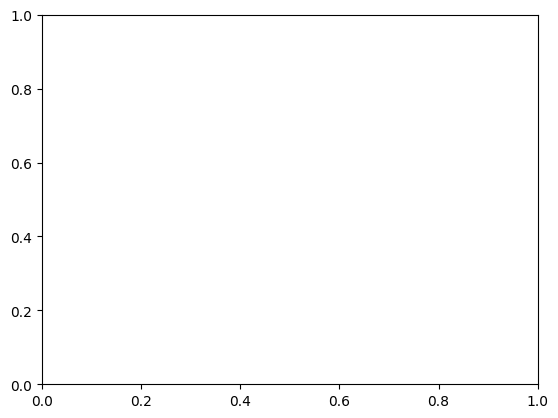

In [47]:
plt.figure()
plt.plot(range(0, 250, 10), batch_iou_list)
plt.title("IoU")
plt.xlabel("Эпоха")
plt.ylabel("IoU")
plt.show()

plt.figure()
plt.plot(batch_loss_list)
plt.title("loss")
plt.xlabel("Эпоха")
plt.ylabel("loss")
plt.show()

In [33]:
model.eval()
with torch.no_grad():
    outputs = model(batch_images)
    preds = (torch.sigmoid(outputs) >= 0.5).float()
    train_iou = iou_score(preds.cpu(), batch_masks.cpu())
    print(f"IoU на 4 обучающих изображениях: {train_iou:.4f}")

    test_ious = []
    for img_t, mask_t in test_dataset:
        img_t = img_t.unsqueeze(0).to(device)
        mask_t = mask_t.unsqueeze(0).to(device)
        out = model(img_t)
        pred_mask = (torch.sigmoid(out) >= 0.5).float()
        iou_val = iou_score(pred_mask.cpu(), mask_t.cpu())
        test_ious.append(iou_val)
    mean_test_iou = sum(test_ious) / len(test_ious)
    print(f"Средний IoU на тестовой выборке: {mean_test_iou:.4f}")

IoU на 4 обучающих изображениях: 0.9750
Средний IoU на тестовой выборке: 0.4852


### Результаты
Видно, что модель обучается и что она даже переобучилась. Но результаты обученной так модели конечно оставляют желать лучшего. IoU и loss перестали улучшаться после 200 итераций.

## Полное обучение модели
batch size 4 взят так, чтобы все данные влезали в видеопамять (6 GB)

In [34]:
import gc

# del model, outputs, preds, loss
gc.collect()
torch.cuda.empty_cache()

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,
                        pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [35]:
from tqdm import tqdm
from torch.amp import autocast, GradScaler

model = UNet(in_channels=3, out_channels=1, base_filters=32).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 50
history = {'train_loss': [], 'val_loss': [], 'train_iou': [], 'val_iou': []}

print("start")
for epoch in range(1, num_epochs + 1):
    model.train()
    total_loss = 0.0
    total_iou = 0.0
    for imgs, masks in tqdm(train_loader, desc='train'):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        preds = (torch.sigmoid(outputs) >= 0.5).float()
        batch_iou = iou_score(preds.cpu(), masks.cpu())
        total_iou += batch_iou

    train_loss = total_loss / len(train_loader)
    train_iou = total_iou / len(train_loader)

    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0
    with torch.no_grad():
        for imgs, masks in tqdm(val_loader, desc="val"):
            imgs = imgs.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            outputs = model(imgs)
            loss = criterion(outputs, masks)
            total_val_loss += loss.item()
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            batch_val_iou = iou_score(preds.cpu(), masks.cpu())
            total_val_iou += batch_val_iou
    val_loss = total_val_loss / len(val_loader) if len(val_loader) > 0 else 0
    val_iou = total_val_iou / len(val_loader) if len(val_loader) > 0 else 0

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_iou'].append(train_iou)
    history['val_iou'].append(val_iou)

    print(
        f"Эпоха {epoch}/{num_epochs} - Loss: {train_loss:.4f} (val {val_loss:.4f}), IoU: {train_iou:.4f} (val {val_iou:.4f})")


start


train:  10%|█         | 35/340 [00:16<02:24,  2.11it/s]


KeyboardInterrupt: 

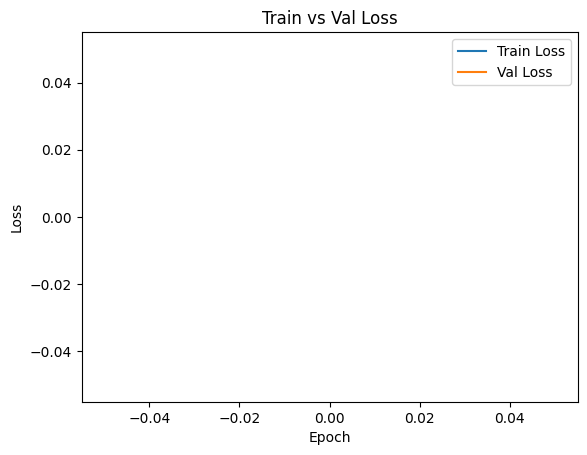

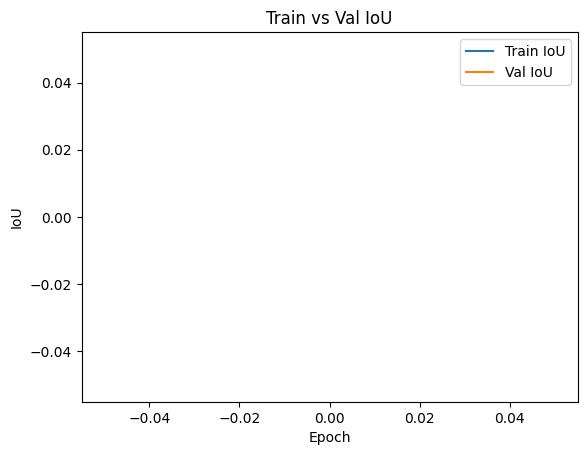

In [36]:
epochs = range(1, len(history['train_loss']) + 1)

plt.figure()
plt.plot(epochs, history['train_loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Val Loss')
plt.legend()
plt.show()

plt.figure()
plt.plot(epochs, history['train_iou'], label='Train IoU')
plt.plot(epochs, history['val_iou'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Train vs Val IoU')
plt.legend()
plt.show()

In [38]:
model.eval()
with torch.no_grad():
    test_ious = []
    for img_t, mask_t in test_dataset:
        img_t = img_t.unsqueeze(0).to(device)
        mask_t = mask_t.unsqueeze(0).to(device)
        out = model(img_t)
        pred_mask = (torch.sigmoid(out) >= 0.5).float()
        iou_val = iou_score(pred_mask.cpu(), mask_t.cpu())
        test_ious.append(iou_val)
    mean_test_iou = sum(test_ious) / len(test_ious)
    print(f"Средний IoU на тестовой выборке: {mean_test_iou:.4f}")

KeyboardInterrupt: 